In [1]:
import treeffuser as tf
import numpy as np
import matplotlib.pyplot as plt
from treeffuser._score_models import LightGBMScore
from treeffuser.sde import VESDE

# load autoreload
%load_ext autoreload
%autoreload 2

In [2]:
n = 1000
X_train1 = np.random.rand(n, 1)
y_train1 = X_train1 + np.random.randn(n, 1) * 0.05 * (X_train1 + 1) ** 2

X_train2 = np.random.rand(n, 1)
y_train2 = - X_train2 + np.random.randn(n, 1) * 0.05 * (X_train2 + 1)**2


X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

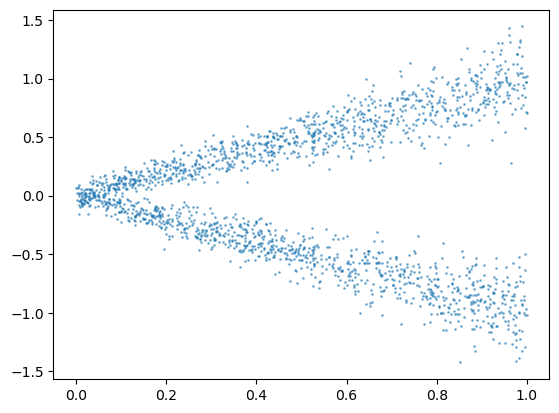

In [3]:
plt.scatter(X_train, y_train, alpha=0.5, s=1)



In [4]:
sde = VESDE(sigma_max=50)
score_model = LightGBMScore(sde=sde, verbose=1, n_repeats=90, n_estimators=10000, learning_rate=0.01, early_stopping_rounds=20, eval_percent=0.1)#, n_estimators=100, n_repeats=10)
score_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 3
[LightGBM] [Info] Start training from score 0.001427
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[908]	valid_0's l2: 0.348061


(100, 1)


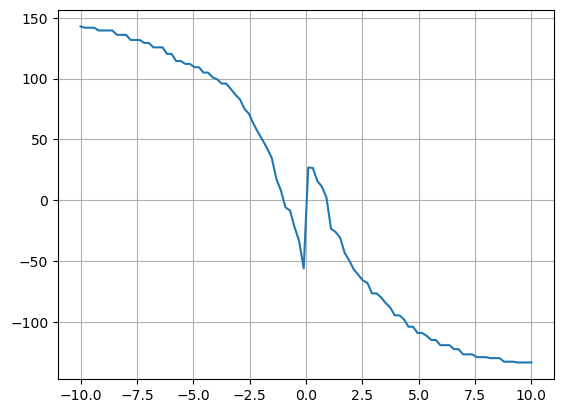

In [5]:
# For t = 0.5 plot the gradient that we get
t = 0.10
x = np.ones(100).reshape(-1,1) * 1
y = np.linspace(-10, 10, 100).reshape(-1, 1)
t_vec = np.ones(100).reshape(-1,1) * t

score = score_model.score(y,x, t_vec)

print(score.shape)
plt.plot(y, score, label='score')
# Add grids
plt.grid()

# change y axis to -1, 1
#plt.ylim(-1, 1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 3
[LightGBM] [Info] Start training from score -0.001686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's l2: 0.224221


100%|██████████| 100/100 [00:01<00:00, 73.86it/s]


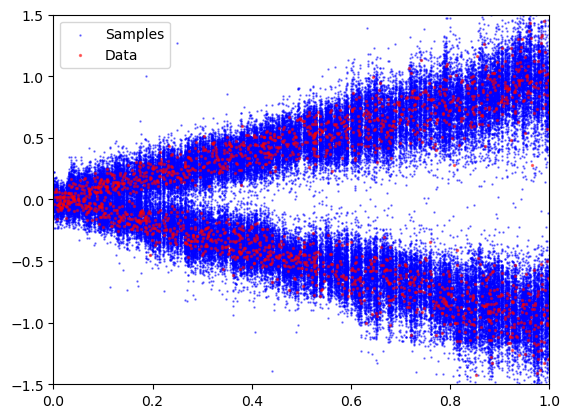

In [6]:
from treeffuser import LightGBMTreeffuser

model = LightGBMTreeffuser(
    verbose=1,
    n_repeats=100,
    n_estimators=1_000,
    sde_name='sub-vpsde',
    learning_rate=0.1,
    early_stopping_rounds=50,
)
model.fit(X_train, y_train)

n_samples = 100
# shape (n , n_samples, y_dim)
idx = np.random.choice(X_train.shape[0], 1000, replace=False)
X_sample = X_train[idx]
y_true = y_train[idx]
y_samples = model.sample(X_sample, n_samples=n_samples, n_parallel=50, n_steps=30, seed=0)
X_repeated = np.repeat(X_sample, n_samples, axis=0)


plt.scatter(X_repeated, y_samples, alpha=0.5, s=0.5, color='blue', label='Samples')
plt.scatter(X_train, y_train, alpha=0.5, s=2, color='red', label='Data')

# set axis to -1, 1
plt.ylim(-1.5, 1.5)
plt.xlim(0, 1)
plt.legend()
plt.show()



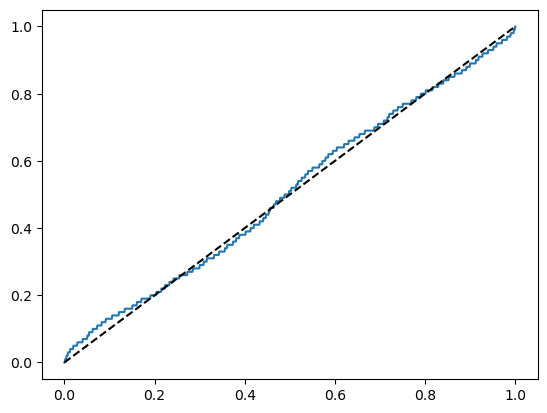

In [7]:
# Look at the calibration of the model
quantiles = []
for i in range(y_true.shape[0]):
    y_true_i = y_true[i][0]
    quantile = np.mean(y_samples[i] <= y_true_i)
    quantiles.append(quantile)

quantiles = np.sort(quantiles)
x = np.linspace(0, 1, y_true.shape[0])
plt.plot(x, quantiles)
plt.plot(x, x, linestyle='--', color='black')